In [1]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import prophet
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import loguniform



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [3]:
import time
start_time = time.time()

df = pd.read_csv("Dataset/dataset-penduduk.csv")
print("Preview Dataset : ")
df.head(10)


Preview Dataset : 


,No,Tahun,Total,Laju Pertumbuhan,Kemiskinan,TFR,Angka Harapan Hidup
0,1,1961,97387000,2.1,58432200.0,6.64,47.30
1,2,1962,99257000,2.1,59554200.0,6.54,48.10
2,3,1963,101221000,2.1,60732600.0,6.44,48.70
3,4,1964,103271000,2.1,61962600.0,6.33,49.40
4,5,1965,105414000,2.1,63248400.0,6.23,42.76
5,6,1966,107645000,2.1,64587000.0,6.13,48.40
6,7,1967,109964000,2.1,65978400.0,6.02,51.30
7,8,1968,112377000,2.1,67426200.0,5.92,51.80
8,9,1969,114880000,2.1,68928000.0,5.82,52.58
9,10,1970,117469000,2.1,70000000.0,5.71,53.25


In [4]:
df.columns

Index(['No', 'Tahun', 'Total', 'Laju Pertumbuhan', 'Kemiskinan', 'TFR',
       'Angka Harapan Hidup'],
      dtype='object')

In [5]:
df['Total'].head(10)

0     97387000
1     99257000
2    101221000
3    103271000
4    105414000
5    107645000
6    109964000
7    112377000
8    114880000
9    117469000
Name: Total, dtype: int64

In [6]:
df['Total'].tail(10)

55    258496500
56    261355500
57    264161600
58    266911900
59    270203900
60    272682500
61    275773800
62    278696200
63    281603800
64    284438800
Name: Total, dtype: int64

In [7]:
print("Total nilai kosong : ")
print(df.isnull().sum())

print("\nNilai duplikat : ",df.duplicated().sum())

df = df.dropna()


Total nilai kosong : 
No                     0
Tahun                  0
Total                  0
Laju Pertumbuhan       1
Kemiskinan             1
TFR                    1
Angka Harapan Hidup    1
dtype: int64

Nilai duplikat :  0


In [8]:
print("Tipe Data : ")
print(df.dtypes)

Tipe Data : 
No                       int64
Tahun                    int64
Total                    int64
Laju Pertumbuhan       float64
Kemiskinan             float64
TFR                    float64
Angka Harapan Hidup    float64
dtype: object


In [9]:

df_prophet = df.drop(columns=['No', 'Laju Pertumbuhan', 'TFR', 'Angka Harapan Hidup', 'Kemiskinan']) 
df_prophet

,Tahun,Total
0,1961,97387000
1,1962,99257000
2,1963,101221000
3,1964,103271000
4,1965,105414000
...,...,...
59,2020,270203900
60,2021,272682500
61,2022,275773800
62,2023,278696200


In [10]:
df_prophet.rename(columns={'Tahun': 'ds', 'Total': 'y'}, inplace=True)
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")  
df_prophet

,ds,y
0,1961-01-01,97387000
1,1962-01-01,99257000
2,1963-01-01,101221000
3,1964-01-01,103271000
4,1965-01-01,105414000
...,...,...
59,2020-01-01,270203900
60,2021-01-01,272682500
61,2022-01-01,275773800
62,2023-01-01,278696200


In [11]:
df.tail(10)

,No,Tahun,Total,Laju Pertumbuhan,Kemiskinan,TFR,Angka Harapan Hidup
54,55,2015,255587500,1.350,28553180.0,2.29,70.10
55,56,2016,258496500,1.350,27884855.0,2.27,71.00
56,57,2017,261355500,1.350,27177105.0,2.25,71.11
57,58,2018,264161600,1.350,25812190.0,2.23,71.20
58,59,2019,266911900,1.350,24965295.0,2.20,71.40
59,60,2020,270203900,1.350,26986855.0,2.18,72.81
60,61,2021,272682500,1.130,27542770.0,2.16,70.70
61,62,2022,275773800,1.050,26161160.0,2.13,71.88
62,63,2023,278696200,1.050,25898550.0,2.11,72.00
63,64,2024,281603800,1.006,24636960.0,2.09,72.20


In [12]:
# scaler = MinMaxScaler()
# df_normalized_prophet = df_prophet
# df_normalized_prophet['y'] = scaler.fit_transform(df_prophet[['y']])
# df_normalized_prophet

In [13]:
#Split data train-test
scaler = MinMaxScaler()
df_prophet['y'] = scaler.fit_transform(df_prophet[['y']])
n = len(df_prophet)
train_size = int(n * 0.85)

df_train = df_prophet.iloc[:train_size]
df_test = df_prophet.iloc[train_size:]

In [14]:
df_train

,ds,y
0,1961-01-01,0.000000
1,1962-01-01,0.010151
2,1963-01-01,0.020812
3,1964-01-01,0.031941
4,1965-01-01,0.043574
5,1966-01-01,0.055684
6,1967-01-01,0.068273
7,1968-01-01,0.081372
8,1969-01-01,0.094959
9,1970-01-01,0.109013


In [15]:
df_test

,ds,y
54,2015-01-01,0.858773
55,2016-01-01,0.874565
56,2017-01-01,0.890084
57,2018-01-01,0.905317
58,2019-01-01,0.920247
59,2020-01-01,0.938117
60,2021-01-01,0.951572
61,2022-01-01,0.968353
62,2023-01-01,0.984216
63,2024-01-01,1.000000


In [16]:
#Inisialisasi model Prophet
# df_train['cap'] = 1.4
model = prophet.Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        # growth='logistic',
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=5,
        n_changepoints=10
    )

model.fit(df_train)



11:12:26 - cmdstanpy - INFO - Chain [1] start processing
11:12:27 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
#Inisialisasi dataframe untuk masa mendatang
df_new = model.make_future_dataframe(
    periods=int(20),freq='Y'
    )
# df_new['cap'] = 1.4

In [18]:
df_test

,ds,y
54,2015-01-01,0.858773
55,2016-01-01,0.874565
56,2017-01-01,0.890084
57,2018-01-01,0.905317
58,2019-01-01,0.920247
59,2020-01-01,0.938117
60,2021-01-01,0.951572
61,2022-01-01,0.968353
62,2023-01-01,0.984216
63,2024-01-01,1.000000


In [19]:
#Forecast
forecast_full = model.predict(df_new)
forecast = forecast_full.iloc[:len(df)]
forecast
# forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1961-01-01,-0.000045,-0.009325,0.008818,-0.000045,-0.000045,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,-0.000521
1,1962-01-01,0.000902,0.000753,0.019383,0.000902,0.000902,10.498459,10.498459,10.498459,10.498459,10.498459,10.498459,0.0,0.0,0.0,0.010374
2,1963-01-01,0.001850,0.012360,0.030392,0.001850,0.001850,10.471323,10.471323,10.471323,10.471323,10.471323,10.471323,0.0,0.0,0.0,0.021219
3,1964-01-01,0.002797,0.023006,0.041090,0.002797,0.002797,10.434817,10.434817,10.434817,10.434817,10.434817,10.434817,0.0,0.0,0.0,0.031985
4,1965-01-01,0.003747,0.034018,0.051873,0.003747,0.003747,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,0.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-12-31,0.080955,0.882256,0.933344,0.078800,0.083239,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.906382
60,2020-12-31,0.082514,0.906293,0.974587,0.079782,0.085558,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.939750
61,2021-12-31,0.084069,0.909688,0.995884,0.080658,0.087932,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.952829
62,2022-12-31,0.085624,0.918938,1.016975,0.081622,0.090200,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.964950


In [20]:
forecast_full

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1961-01-01,-0.000045,-0.009325,0.008818,-0.000045,-0.000045,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,-0.000521
1,1962-01-01,0.000902,0.000753,0.019383,0.000902,0.000902,10.498459,10.498459,10.498459,10.498459,10.498459,10.498459,0.0,0.0,0.0,0.010374
2,1963-01-01,0.001850,0.012360,0.030392,0.001850,0.001850,10.471323,10.471323,10.471323,10.471323,10.471323,10.471323,0.0,0.0,0.0,0.021219
3,1964-01-01,0.002797,0.023006,0.041090,0.002797,0.002797,10.434817,10.434817,10.434817,10.434817,10.434817,10.434817,0.0,0.0,0.0,0.031985
4,1965-01-01,0.003747,0.034018,0.051873,0.003747,0.003747,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,0.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2029-12-31,0.096519,0.979470,1.214168,0.086273,0.107277,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,1.093932
70,2030-12-31,0.098074,0.976596,1.237036,0.086692,0.109664,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,1.105252
71,2031-12-31,0.099629,0.972467,1.261636,0.087033,0.112302,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,1.115464
72,2032-12-31,0.101188,0.996379,1.314092,0.087522,0.115052,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,1.152432


In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1961-01-01,-0.000045,-0.009325,0.008818,-0.000045,-0.000045,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,-0.000521
1,1962-01-01,0.000902,0.000753,0.019383,0.000902,0.000902,10.498459,10.498459,10.498459,10.498459,10.498459,10.498459,0.0,0.0,0.0,0.010374
2,1963-01-01,0.001850,0.012360,0.030392,0.001850,0.001850,10.471323,10.471323,10.471323,10.471323,10.471323,10.471323,0.0,0.0,0.0,0.021219
3,1964-01-01,0.002797,0.023006,0.041090,0.002797,0.002797,10.434817,10.434817,10.434817,10.434817,10.434817,10.434817,0.0,0.0,0.0,0.031985
4,1965-01-01,0.003747,0.034018,0.051873,0.003747,0.003747,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,0.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-12-31,0.080955,0.882256,0.933344,0.078800,0.083239,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.906382
60,2020-12-31,0.082514,0.906293,0.974587,0.079782,0.085558,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.939750
61,2021-12-31,0.084069,0.909688,0.995884,0.080658,0.087932,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.952829
62,2022-12-31,0.085624,0.918938,1.016975,0.081622,0.090200,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.964950


In [22]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1961-01-01,-0.000045,-0.009325,0.008818,-0.000045,-0.000045,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,-0.000521
1,1962-01-01,0.000902,0.000753,0.019383,0.000902,0.000902,10.498459,10.498459,10.498459,10.498459,10.498459,10.498459,0.0,0.0,0.0,0.010374
2,1963-01-01,0.001850,0.012360,0.030392,0.001850,0.001850,10.471323,10.471323,10.471323,10.471323,10.471323,10.471323,0.0,0.0,0.0,0.021219
3,1964-01-01,0.002797,0.023006,0.041090,0.002797,0.002797,10.434817,10.434817,10.434817,10.434817,10.434817,10.434817,0.0,0.0,0.0,0.031985
4,1965-01-01,0.003747,0.034018,0.051873,0.003747,0.003747,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,0.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-12-31,0.080955,0.882256,0.933344,0.078800,0.083239,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.906382
60,2020-12-31,0.082514,0.906293,0.974587,0.079782,0.085558,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.939750
61,2021-12-31,0.084069,0.909688,0.995884,0.080658,0.087932,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.952829
62,2022-12-31,0.085624,0.918938,1.016975,0.081622,0.090200,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.964950


In [23]:
# hasil_prediksi = scaler.inverse_transform(forecast_full['yhat'].values.reshape(-1, 1))
hasil_prediksi = forecast_full['yhat'].values.reshape(-1, 1)
hasil_prediksi

array([[-5.20875607e-04],
       [ 1.03743275e-02],
       [ 2.12185351e-02],
       [ 3.19851112e-02],
       [ 4.31538261e-02],
       [ 5.59172516e-02],
       [ 6.85848836e-02],
       [ 8.11254803e-02],
       [ 9.45876661e-02],
       [ 1.09562683e-01],
       [ 1.24389095e-01],
       [ 1.39030209e-01],
       [ 1.55205076e-01],
       [ 1.70086755e-01],
       [ 1.80252359e-01],
       [ 1.90212098e-01],
       [ 2.02203125e-01],
       [ 2.12483776e-01],
       [ 2.25993479e-01],
       [ 2.39240845e-01],
       [ 2.55047880e-01],
       [ 2.68699463e-01],
       [ 2.92646845e-01],
       [ 3.16218800e-01],
       [ 3.43214405e-01],
       [ 3.67325581e-01],
       [ 3.88466327e-01],
       [ 4.09167657e-01],
       [ 4.34233698e-01],
       [ 4.55624755e-01],
       [ 4.69707134e-01],
       [ 4.83321740e-01],
       [ 5.02019874e-01],
       [ 5.16440368e-01],
       [ 5.30379225e-01],
       [ 5.42743216e-01],
       [ 5.60796245e-01],
       [ 5.74062819e-01],
       [ 5.8

In [24]:
tahun_awal = 1961
tahun = np.arange(tahun_awal, tahun_awal + len(hasil_prediksi))

# buat DataFrame
df_prediksi = pd.DataFrame({
    "Tahun": tahun,
    "Prediksi": hasil_prediksi.flatten()
})


In [25]:
y_pred = df_prediksi[df_prediksi['Tahun'] <= 2025]['Prediksi'].values
y_pred = y_pred[train_size:]


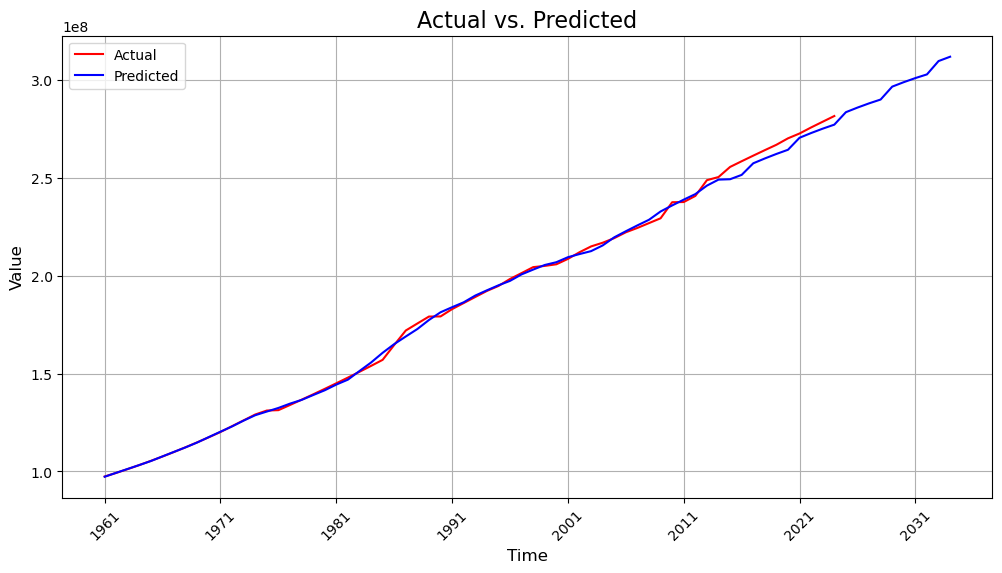

In [26]:
# 1. Membuat kanvas dan mengatur ukuran
plt.figure(figsize=(12, 6))

# 2. Plot nilai aktual (merah)
plt.plot(range(len(df)), df['Total'], label='Actual', color='red')

# 3. Plot nilai prediksi (biru)
plt.plot(range(len(forecast_full)), scaler.inverse_transform(forecast_full['yhat'].values.reshape(-1, 1)), label='Predicted', color='blue')


# 4. Menambahkan judul dan label
plt.title('Actual vs. Predicted', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)


start_year = 1961
interval = 10 
tick_positions = range(0, len(forecast_full), interval)
tick_labels = [start_year + pos for pos in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.show()

In [27]:
forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1961-01-01,-0.000045,-0.009325,0.008818,-0.000045,-0.000045,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,-0.000521
1,1962-01-01,0.000902,0.000753,0.019383,0.000902,0.000902,10.498459,10.498459,10.498459,10.498459,10.498459,10.498459,0.0,0.0,0.0,0.010374
2,1963-01-01,0.001850,0.012360,0.030392,0.001850,0.001850,10.471323,10.471323,10.471323,10.471323,10.471323,10.471323,0.0,0.0,0.0,0.021219
3,1964-01-01,0.002797,0.023006,0.041090,0.002797,0.002797,10.434817,10.434817,10.434817,10.434817,10.434817,10.434817,0.0,0.0,0.0,0.031985
4,1965-01-01,0.003747,0.034018,0.051873,0.003747,0.003747,10.516191,10.516191,10.516191,10.516191,10.516191,10.516191,0.0,0.0,0.0,0.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-12-31,0.080955,0.882256,0.933344,0.078800,0.083239,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.906382
60,2020-12-31,0.082514,0.906293,0.974587,0.079782,0.085558,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.939750
61,2021-12-31,0.084069,0.909688,0.995884,0.080658,0.087932,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.952829
62,2022-12-31,0.085624,0.918938,1.016975,0.081622,0.090200,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.964950


In [28]:
df_forecast = forecast.iloc[train_size:]
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
54,2014-12-31,0.073175,0.815551,0.834088,0.073175,0.073187,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.824648
55,2015-12-31,0.074730,0.826480,0.847484,0.074513,0.074988,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.836688
56,2016-12-31,0.076289,0.856602,0.882106,0.075721,0.076968,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.868856
57,2017-12-31,0.077844,0.867998,0.898701,0.076926,0.078978,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.882278
58,2018-12-31,0.079399,0.875814,0.915061,0.077925,0.081055,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.894799
59,2019-12-31,0.080955,0.882256,0.933344,0.078800,0.083239,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.906382
60,2020-12-31,0.082514,0.906293,0.974587,0.079782,0.085558,10.388985,10.388985,10.388985,10.388985,10.388985,10.388985,0.0,0.0,0.0,0.939750
61,2021-12-31,0.084069,0.909688,0.995884,0.080658,0.087932,10.333888,10.333888,10.333888,10.333888,10.333888,10.333888,0.0,0.0,0.0,0.952829
62,2022-12-31,0.085624,0.918938,1.016975,0.081622,0.090200,10.269594,10.269594,10.269594,10.269594,10.269594,10.269594,0.0,0.0,0.0,0.964950
63,2023-12-31,0.087179,0.919944,1.037436,0.082426,0.092526,10.196186,10.196186,10.196186,10.196186,10.196186,10.196186,0.0,0.0,0.0,0.976076


In [29]:
yhat_train = forecast.iloc[:train_size]
yhat_train = yhat_train['yhat']
yhat_train

0    -0.000521
1     0.010374
2     0.021219
3     0.031985
4     0.043154
5     0.055917
6     0.068585
7     0.081125
8     0.094588
9     0.109563
10    0.124389
11    0.139030
12    0.155205
13    0.170087
14    0.180252
15    0.190212
16    0.202203
17    0.212484
18    0.225993
19    0.239241
20    0.255048
21    0.268699
22    0.292647
23    0.316219
24    0.343214
25    0.367326
26    0.388466
27    0.409168
28    0.434234
29    0.455625
30    0.469707
31    0.483322
32    0.502020
33    0.516440
34    0.530379
35    0.542743
36    0.560796
37    0.574063
38    0.586805
39    0.594509
40    0.608405
41    0.617093
42    0.625238
43    0.641031
44    0.663552
45    0.680411
46    0.696645
47    0.712211
48    0.735238
49    0.751987
50    0.768052
51    0.783390
52    0.806923
53    0.823563
Name: yhat, dtype: float64

In [30]:
perbandingan_train = df_train
perbandingan_train['yhat'] = yhat_train
perbandingan_train

C:\Users\Radit\AppData\Local\Temp\ipykernel_4044\768979714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perbandingan_train['yhat'] = yhat_train


,ds,y,yhat
0,1961-01-01,0.000000,-0.000521
1,1962-01-01,0.010151,0.010374
2,1963-01-01,0.020812,0.021219
3,1964-01-01,0.031941,0.031985
4,1965-01-01,0.043574,0.043154
5,1966-01-01,0.055684,0.055917
6,1967-01-01,0.068273,0.068585
7,1968-01-01,0.081372,0.081125
8,1969-01-01,0.094959,0.094588
9,1970-01-01,0.109013,0.109563


In [31]:
df_test

,ds,y
54,2015-01-01,0.858773
55,2016-01-01,0.874565
56,2017-01-01,0.890084
57,2018-01-01,0.905317
58,2019-01-01,0.920247
59,2020-01-01,0.938117
60,2021-01-01,0.951572
61,2022-01-01,0.968353
62,2023-01-01,0.984216
63,2024-01-01,1.000000


In [32]:
# filtered_res = res[(res['ds'] <= '2023-01-01')]
# y_actual = df['y']
# y_pred = filtered_res['yhat']

# Step 5: Evaluasi
y_true = df_test['y'].values
y_pred = forecast.iloc[train_size:]['yhat'].values



In [33]:
df_test

,ds,y
54,2015-01-01,0.858773
55,2016-01-01,0.874565
56,2017-01-01,0.890084
57,2018-01-01,0.905317
58,2019-01-01,0.920247
59,2020-01-01,0.938117
60,2021-01-01,0.951572
61,2022-01-01,0.968353
62,2023-01-01,0.984216
63,2024-01-01,1.000000


In [34]:
y_true

array([0.85877347, 0.87456464, 0.8900844 , 0.905317  , 0.92024669,
       0.93811694, 0.95157174, 0.96835251, 0.98421642, 1.        ])

In [35]:
y_pred

array([0.82464816, 0.83668813, 0.86885595, 0.8822783 , 0.89479911,
       0.90638213, 0.93975008, 0.95282947, 0.96495005, 0.97607613])

In [36]:
# Menghitung MAE
mae = mean_absolute_error(y_true, y_pred) 

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 

# Menghitung MAPE
mape = mean_absolute_percentage_error(y_true, y_pred) * 100


print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')


MAE: 0.0244
RMSE: 0.0256
MAPE: 2.6578%


In [37]:
#Hasil Prediksi Angka Populasi Penduduk di Masa Mendatang
forecast_result = forecast_full[['ds', 'yhat']]
forecast_result['yhat'] = scaler.inverse_transform(forecast_result['yhat'].values.reshape(-1, 1))
forecast_result[(forecast_result['ds'] >= '2024-01-01')]

C:\Users\Radit\AppData\Local\Temp\ipykernel_4044\4120084099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['yhat'] = scaler.inverse_transform(forecast_result['yhat'].values.reshape(-1, 1))


,ds,yhat
64,2024-12-31,2.835646e+08
65,2025-12-31,2.859109e+08
66,2026-12-31,2.880700e+08
67,2027-12-31,2.900354e+08
68,2028-12-31,2.966245e+08
69,2029-12-31,2.989076e+08
70,2030-12-31,3.009930e+08
71,2031-12-31,3.028742e+08
72,2032-12-31,3.096844e+08
73,2033-12-31,3.119043e+08


In [38]:
forecast_result['yhat'] = forecast_result['yhat'].astype(int)
forecast_result

C:\Users\Radit\AppData\Local\Temp\ipykernel_4044\1201647493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['yhat'] = forecast_result['yhat'].astype(int)


,ds,yhat
0,1961-01-01,97291045
1,1962-01-01,99298125
2,1963-01-01,101295810
3,1964-01-01,103279194
4,1965-01-01,105336659
...,...,...
69,2029-12-31,298907615
70,2030-12-31,300992976
71,2031-12-31,302874231
72,2032-12-31,309684426


In [39]:
forecast_result[(forecast_result['ds'] >= '2014-01-01')]


,ds,yhat
53,2014-01-01,249101073
54,2014-12-31,249301044
55,2015-12-31,251519010
56,2016-12-31,257444861
57,2017-12-31,259917485
58,2018-12-31,262224027
59,2019-12-31,264357815
60,2020-12-31,270504753
61,2021-12-31,272914195
62,2022-12-31,275147010


In [40]:
df

,No,Tahun,Total,Laju Pertumbuhan,Kemiskinan,TFR,Angka Harapan Hidup
0,1,1961,97387000,2.100,58432200.0,6.64,47.30
1,2,1962,99257000,2.100,59554200.0,6.54,48.10
2,3,1963,101221000,2.100,60732600.0,6.44,48.70
3,4,1964,103271000,2.100,61962600.0,6.33,49.40
4,5,1965,105414000,2.100,63248400.0,6.23,42.76
...,...,...,...,...,...,...,...
59,60,2020,270203900,1.350,26986855.0,2.18,72.81
60,61,2021,272682500,1.130,27542770.0,2.16,70.70
61,62,2022,275773800,1.050,26161160.0,2.13,71.88
62,63,2023,278696200,1.050,25898550.0,2.11,72.00


In [41]:
df['Total'][(df['Tahun'] >= 2014)]

53    250421446
54    255587500
55    258496500
56    261355500
57    264161600
58    266911900
59    270203900
60    272682500
61    275773800
62    278696200
63    281603800
Name: Total, dtype: int64